In [1]:
setwd('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.5_Baseline Cluster Analyses/Input')
Output = ('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.5_Baseline Cluster Analyses/Output')
cur_date = "012021"

library(readxl)
library(dplyr)
library(plyr)
library(tidyverse)
library(janitor)
#library(ltm)
require(foreign)
require(nnet)
require(ggplot2)
require(reshape2)
#library(effects)
library(missForest)
library(tidyr)

#reading in file
cytokines <- data.frame(read_excel("CytokineData_102920.xlsx", sheet = 2))

#reading in demographics file
subjectinfo = data.frame(read_excel("SubjectInfo_102920.xlsx", sheet = 2))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ stringr 1.4.0
✔ tidyr   1.1.2     ✔ forcats 0.5.0
✔ readr   1.3.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts

In [ ]:
#dichotomizing variables
for (i in 1:length(subjectinfo$Race)){
    if(subjectinfo$Race[i] != 'W'){
        subjectinfo$Race[i] = 'NW'
    } 
    if(subjectinfo$Age[i] <= 30){
        subjectinfo$Age[i] = 'U' #under 30
    } 
    else {
        subjectinfo$Age[i] = 'O' #over 30
    }
}

for (i in 1:length(subjectinfo$Race)){
    if (i != 32){ #ignoring NA value
        if(subjectinfo$BMI[i] < 25){
            subjectinfo$BMI[i] = 'N' #normal bmi
    }
        else {
            subjectinfo$BMI[i] = 'O' #overweight
        }
    }
}

In [2]:
#upload cytokine data for each compartment 
ELF_cyto <- read.csv("011921ELF_NonNorm.csv")
NLF_cyto <- read.csv("011921NLF_NonNorm.csv")
Serum_cyto <- read.csv("011921Serum_NonNorm.csv")
Sputum_cyto <- read.csv("011921Sputum_NonNorm.csv")

#transpose cytokine data for each compartment
ELF_cyto <- as.data.frame(t(ELF_cyto)) %>% 
  row_to_names(row_number = 1)
NLF_cyto <- as.data.frame(t(NLF_cyto)) %>% 
  row_to_names(row_number = 1)
Serum_cyto <- as.data.frame(t(Serum_cyto)) %>% 
  row_to_names(row_number = 1)
Sputum_cyto <- as.data.frame(t(Sputum_cyto)) %>% 
  row_to_names(row_number = 1)

#cluster assignments for each compartment 
ELF_clus <- read.csv("011921ELF_cluster_assignments.csv")
NLF_clus <- read.csv("011921NLF_cluster_assignments.csv")
Serum_clus <- read.csv("011921Serum_cluster_assignments.csv")
Sputum_clus <- read.csv("011921Sputum_cluster_assignments.csv")

#reading in scaled data
ELF_cyto_scaled <- read.csv("011921ELF_Scaled.csv")
NLF_cyto_scaled <- read.csv("011921NLF_Scaled.csv")
Serum_cyto_scaled <- read.csv("011921Serum_Scaled.csv")
Sputum_cyto_scaled <- read.csv("011921Sputum_Scaled.csv")

In [3]:
#renaming first column, grouping and splitting by "Cluster" column
ELF_clus <- ELF_clus %>% 
  dplyr::rename(Cytokine = X) %>% 
  group_by(Cluster) %>% 
  group_split
NLF_clus <- NLF_clus %>% 
  dplyr::rename(Cytokine = X) %>% 
  group_by(Cluster) %>% 
  group_split
Serum_clus <- Serum_clus %>% 
  dplyr::rename(Cytokine = X) %>% 
  group_by(Cluster) %>% 
  group_split
Sputum_clus <- Sputum_clus %>% 
  dplyr::rename(Cytokine = X) %>% 
  group_by(Cluster) %>% 
  group_split

#making dfs for each cluster for PCA analysis 
ELF_1 <- ELF_clus[[1]]
ELF_2 <- ELF_clus[[2]]
ELF_3 <- ELF_clus[[3]]

NLF_1 <- NLF_clus[[1]]
NLF_2 <- NLF_clus[[2]]
NLF_3 <- NLF_clus[[3]]

Serum_1 <- Serum_clus[[1]]
Serum_2 <- Serum_clus[[2]]
Serum_3 <- Serum_clus[[3]]

Sputum_1 <- Sputum_clus[[1]]
Sputum_2 <- Sputum_clus[[2]]
Sputum_3 <- Sputum_clus[[3]]

#making df with subjects' cytokine concentration data for each cluster 
ELF_1 <- ELF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% ELF_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
ELF_2 <- ELF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% ELF_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
ELF_3 <- ELF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% ELF_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

NLF_1 <- NLF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% NLF_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
NLF_2 <- NLF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% NLF_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
NLF_3 <- NLF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% NLF_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

Serum_1 <- Serum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Serum_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Serum_2 <- Serum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Serum_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Serum_3 <- Serum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Serum_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

Sputum_1 <- Sputum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Sputum_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Sputum_2 <- Sputum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Sputum_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Sputum_3 <- Sputum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Sputum_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

In [4]:
#PCA on each cluster, eigenvectors are in rotation -- PROBLEM - for some reason had to convert everything to numeric  
pca_ELF_1 <- ELF_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_ELF_2 <- ELF_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_ELF_3 <- ELF_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>%   
  prcomp()

pca_NLF_1 <- NLF_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_NLF_2 <- NLF_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_NLF_3 <- NLF_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()

pca_Serum_1 <- Serum_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Serum_2 <- Serum_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Serum_3 <- Serum_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()

pca_Sputum_1 <- Sputum_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Sputum_2 <- Sputum_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Sputum_3 <- Sputum_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()

#eigenvector dfs of first principal component 
eigencytokines_ELF_1 <- data.frame(pca_ELF_1$rotation[,"PC1"])
  colnames(eigencytokines_ELF_1)[1] <- "Cluster1"
eigencytokines_ELF_2 <- data.frame(pca_ELF_2$rotation[,"PC1"])
  colnames(eigencytokines_ELF_2)[1] <- "Cluster2"
eigencytokines_ELF_3 <- data.frame(pca_ELF_3$rotation[,"PC1"])
  colnames(eigencytokines_ELF_3)[1] <- "Cluster3"

eigencytokines_NLF_1 <- data.frame(pca_NLF_1$rotation[,"PC1"])
  colnames(eigencytokines_NLF_1)[1] <- "Cluster1"
eigencytokines_NLF_2 <- data.frame(pca_NLF_2$rotation[,"PC1"])
  colnames(eigencytokines_NLF_2)[1] <- "Cluster2"
eigencytokines_NLF_3 <- data.frame(pca_NLF_3$rotation[,"PC1"])
  colnames(eigencytokines_NLF_3)[1] <- "Cluster3"
  
eigencytokines_Serum_1 <- data.frame(pca_Serum_1$rotation[,"PC1"])
  colnames(eigencytokines_Serum_1)[1] <- "Cluster1"
eigencytokines_Serum_2 <- data.frame(pca_Serum_2$rotation[,"PC1"])
  colnames(eigencytokines_Serum_2)[1] <- "Cluster2"
eigencytokines_Serum_3 <- data.frame(pca_Serum_3$rotation[,"PC1"])
  colnames(eigencytokines_Serum_3)[1] <- "Cluster3"

eigencytokines_Sputum_1 <- data.frame(pca_Sputum_1$rotation[,"PC1"])
  colnames(eigencytokines_Sputum_1)[1] <- "Cluster1"
eigencytokines_Sputum_2 <- data.frame(pca_Sputum_2$rotation[,"PC1"])
  colnames(eigencytokines_Sputum_2)[1] <- "Cluster2"
eigencytokines_Sputum_3 <- data.frame(pca_Sputum_3$rotation[,"PC1"])
  colnames(eigencytokines_Sputum_3)[1] <- "Cluster3"
  

#collapse all eigencytokine dfs
eigencytokines_ELF <- cbind(eigencytokines_ELF_1, eigencytokines_ELF_2, eigencytokines_ELF_3)
eigencytokines_NLF <- cbind(eigencytokines_NLF_1, eigencytokines_NLF_2, eigencytokines_NLF_3)
eigencytokines_Serum <- cbind(eigencytokines_Serum_1, eigencytokines_Serum_2, eigencytokines_Serum_3)
eigencytokines_Sputum <- cbind(eigencytokines_Sputum_1, eigencytokines_Sputum_2, eigencytokines_Sputum_3)

#scale all eigencytokine dfs
eigencytokines_ELF_scaled <- as.data.frame(scale(eigencytokines_ELF))
eigencytokines_NLF_scaled <- as.data.frame(scale(eigencytokines_NLF))
eigencytokines_Serum_scaled <- as.data.frame(scale(eigencytokines_Serum))
eigencytokines_Sputum_scaled <- as.data.frame(scale(eigencytokines_Sputum))

In [ ]:
#export all eigencytokine dfs
write.csv(eigencytokines_ELF, paste0(Output_Folder,"/", "eigencytokines_ELF.csv"), row.names=TRUE)
write.csv(eigencytokines_NLF, paste0(Output_Folder,"/", "eigencytokines_NLF.csv"), row.names=TRUE)
write.csv(eigencytokines_Serum, paste0(Output_Folder,"/", "eigencytokines_Serum.csv"), row.names=TRUE)
write.csv(eigencytokines_Sputum, paste0(Output_Folder,"/", "eigencytokines_Sputum.csv"), row.names=TRUE)

write.csv(eigencytokines_ELF_scaled, paste0(Output_Folder,"/", "eigencytokines_ELF_scaled.csv"), row.names=TRUE)
write.csv(eigencytokines_NLF_scaled, paste0(Output_Folder,"/", "eigencytokines_NLF_scaled.csv"), row.names=TRUE)
write.csv(eigencytokines_Serum_scaled, paste0(Output_Folder,"/", "eigencytokines_Serum_scaled.csv"), row.names=TRUE)
write.csv(eigencytokines_Sputum_scaled, paste0(Output_Folder,"/", "eigencytokines_Sputum_scaled.csv"), row.names=TRUE)

Now that they eigencytokines have been obtained NLF Cluster 3 needs to be separated out. 

In [5]:
names(NLF_cyto_scaled)[1] = 'SubjectID' #reanaming column
eigencytokines_NLF_scaled = eigencytokines_NLF_scaled %>%
    rownames_to_column(var = 'SubjectID')
NLF_df = full_join(NLF_cyto_scaled,eigencytokines_NLF_scaled)
NLF_df$SubjectID = factor(NLF_df$SubjectID, levels = c('NS_1', 'NS_2', 'NS_3', 'NS_4', 'NS_5', 'NS_6', 'NS_7', 'NS_8',
                                                      'NS_9', 'NS_10', 'NS_11', 'NS_12', 'NS_13', 'NS_14'))

Joining, by = "SubjectID"



,SubjectID,Eotaxin,Eotaxin3,Fractalkine,IFNg,IL10,IL12p70,IL13,IL17B,IL17D,⋯,ITAC,MCP1,MIG,MIP1a,MIP1b,TARC,TNFa,Cluster1,Cluster2,Cluster3
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NS_1,-0.5630023,-0.4805081,0.6681523,-0.5658910,-0.4260711,-0.8556839,0.6396792,-0.36710910,1.2349944,⋯,0.54007928,0.9936539,1.0919614,-0.7371228,-0.66788368,-0.4377484,0.77256144,0.05976271,-0.5327417,-0.4632075
2,NS_10,1.2478897,1.3468201,0.9244682,-0.4538609,-0.4448040,-0.1679861,-0.2004044,0.73336772,0.1071045,⋯,-0.40266259,0.8703994,-0.2025715,1.0662956,0.54592172,0.6105605,0.09613807,1.28595874,0.1480348,0.3705725
3,NS_11,-0.7282788,-0.1330557,-1.4374693,-0.5760338,-0.7368060,-0.8556839,-0.6728642,0.19905648,-0.9462910,⋯,-1.17556020,-1.6267736,-0.9085956,0.5278317,-0.60990041,-1.4041857,-0.87437554,-0.40206720,1.1052660,0.3923003
4,NS_12,0.2345743,-0.9425648,0.6237986,0.4574383,0.2951032,-0.8556839,1.7114512,0.36290325,-0.9462910,⋯,-0.06783334,-0.4230925,-0.6639902,-0.0413928,0.01950975,0.3642943,1.63936190,-1.75904217,-0.5637463,0.8129353
5,NS_13,0.8426756,0.9207279,0.6106723,0.4395231,0.1961496,0.3127131,1.1794078,0.09373333,1.8859341,⋯,1.41419945,0.7520983,1.2282097,-0.1673460,-0.07109781,1.1577067,0.49321311,0.61477421,-1.2849277,0.1599047
6,NS_14,0.6561918,-0.2125826,0.3720205,0.2925256,1.0040754,0.7873924,1.2207548,-0.51683698,2.0273798,⋯,1.20029363,0.3661717,1.9264547,0.1590909,0.30538560,-0.3759048,0.77134019,0.27367554,-1.7859351,0.2445334


In [11]:
NLF_Cluster3_df = melt(NLF_df) %>%
    filter(variable == c('Cluster3', 'IL8', 'IP10', 'MIG'))
head(NLF_Cluster3_df)

Using SubjectID as id variables



,SubjectID,variable,value
,<fct>,<fct>,<dbl>
1,NS_10,IL8,0.9605292
2,NS_14,IL8,0.3789175
3,NS_5,IL8,0.8885852
4,NS_9,IL8,-0.8011187
5,NS_1,IP10,-0.1279384
6,NS_13,IP10,0.5133255


# Visualization of Eigenvector (Figure 4)

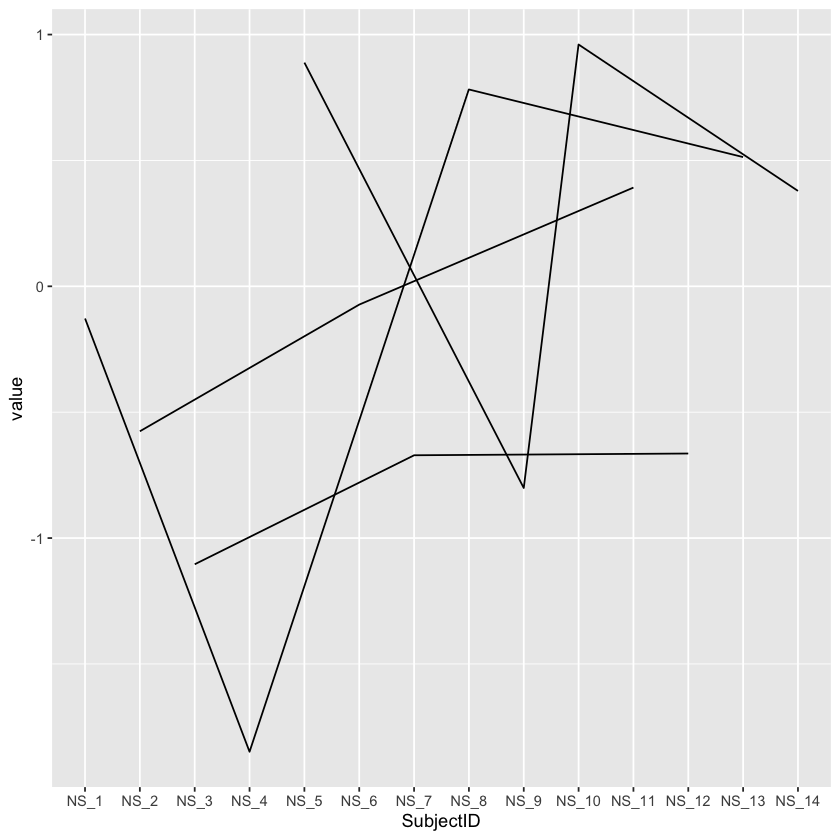

In [12]:
ggplot(data = NLF_Cluster3_df) + 
    geom_line(aes(x = SubjectID, y = value, group = variable))

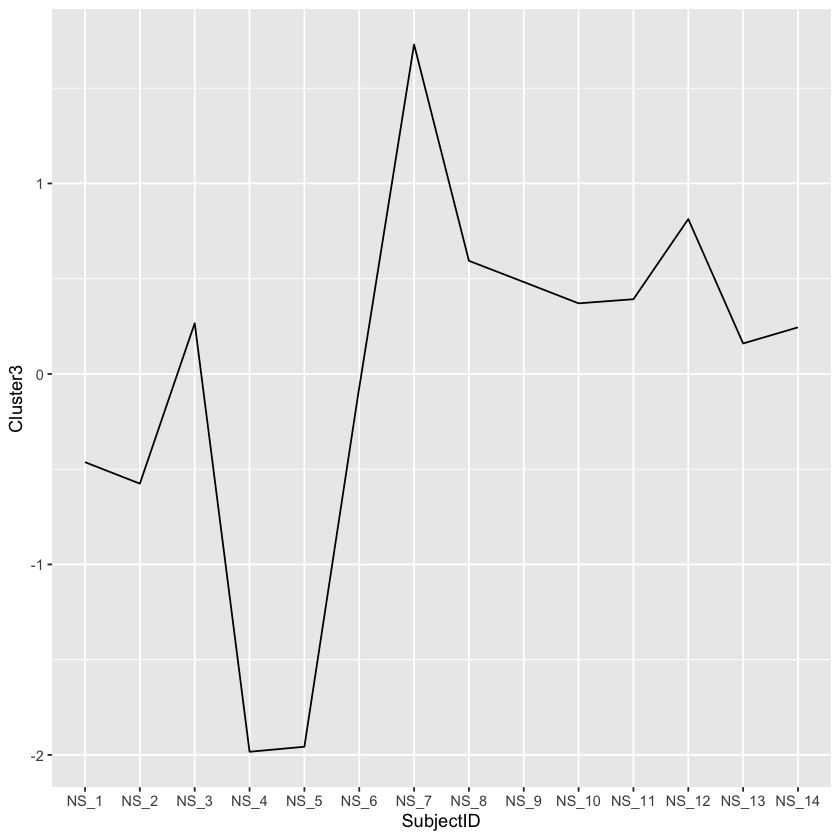

In [8]:
ggplot(data = NLF_df) + 
  geom_line(aes(x = SubjectID, y = Cluster3, group = 1, color), size = 3) + 
  geom_line(aes(x = SubjectID, y = Fractalkine, group = 1)) + 
  geom_line(aes(x = SubjectID, y = MIG, group = 1)) + 
  geom_line(aes(x = SubjectID, y = IP10, group = 1)) + 
  geom_line(aes(x = SubjectID, y = IL8, group = 1)) 